In [288]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import leidenalg
import igraph as ig
import random
import numpy as np
import cdlib.algorithms

## **0. Carga del grafo**

In [166]:
start = time.time()

G: nx.Graph = nx.read_graphml("hashtags_cleaned.graphml")

minutos, segundos = divmod(time.time()-start, 60)
print(f"****Tiempo de lectura: {int(minutos)} minutos y {segundos:.2f} segundos****")

****Tiempo de lectura: 0 minutos y 6.29 segundos****


### Subgrafo de prueba

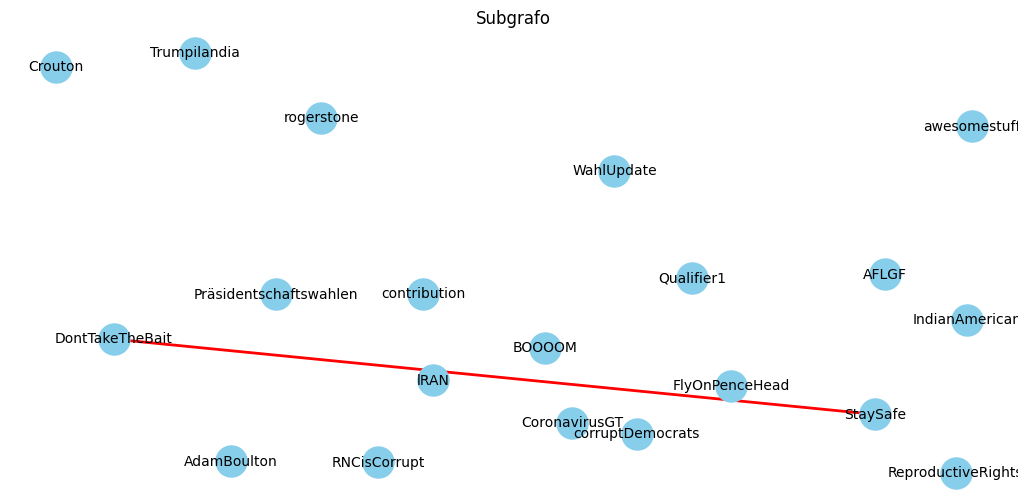

In [287]:
nodos_seleccionados = random.sample(sorted(G.nodes), k=20)

subgrafo = G.subgraph(nodos_seleccionados)
pos = nx.random_layout(subgrafo, seed=33)  # Puedes probar otros layouts como circular_layout

plt.figure(figsize=(13, 6))
nx.draw_networkx_nodes(subgrafo, pos, node_color='skyblue', node_size=500)

nx.draw_networkx_edges(subgrafo, pos, edge_color='red', width=2)
nx.draw_networkx_labels(subgrafo, pos, font_size=10, font_color="black")

plt.title("Subgrafo")
plt.axis("off")
plt.show()

## **1. Cálculo de comunidades**

In [258]:
G_igraph = ig.Graph.from_networkx(G)
partitions = []
modularities = []
for i in range(10):
    partition = leidenalg.find_partition(G_igraph, leidenalg.ModularityVertexPartition)
    partitions.append(len(partition))
    modularities.append(round(partition.modularity, ndigits=3))

print(f"Nº comunidades: {partitions}")
print(f"Modularidades: {modularities}")
print(f"La media del número de comunidades es: {np.mean(partitions)}")
# print(len(set(partition.membership)))

Nº comunidades: [51, 38, 64, 64, 47, 47, 53, 43, 43, 49]
Modularidades: [0.412, 0.404, 0.398, 0.398, 0.412, 0.412, 0.412, 0.412, 0.412, 0.414]
La media del número de comunidades es: 49.9


---

In [344]:
leiden_comms = cdlib.algorithms.leiden(G).to_node_community_map()
nodes_dict = {k:v[0] for k,v in leiden_comms.items()} # 47544 nodes
communities = set(nodes_dict.values())
print("Número de comunidades:", len(communities))

Número de comunidades: 53


## **2. Representación compacta**

1. coger cada comunidad, crear un nodo representante
2. sumar pesos de aristas con el resto de comunidades

In [359]:
communities = list(communities)
com_index = 48
print("com_index:", com_index)
claves_con_valor = [clave for clave, valor in nodes_dict.items() if valor == com_index]

print(f"nodes in com {com_index}:", len(claves_con_valor))

com_index: 48
nodes in com 48: 4


---

{}

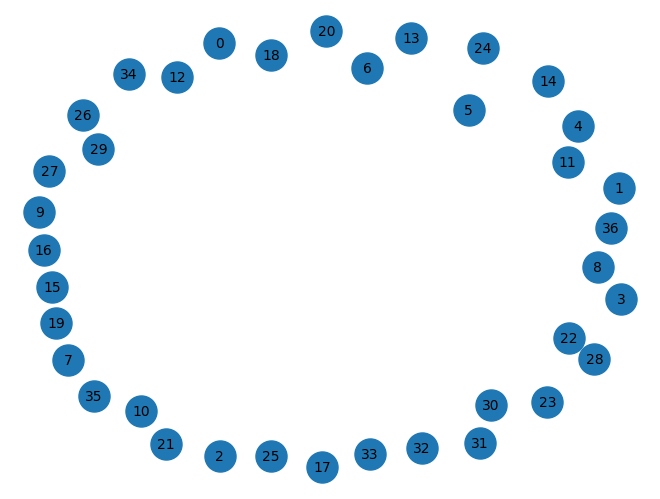

In [25]:
# Crear un diccionario que mapea cada nodo a su comunidad
# Nos aseguramos de incluir todos los nodos del grafo
node_to_community = {}

for community, nodes in enumerate(partition):
    for node in nodes:
        if node in G.nodes:
            node_to_community[node] = community

# Crear un nuevo grafo compacto
compact_graph = nx.Graph()

# Agregar nodos para cada comunidad
for community in range(len(partition)):
    compact_graph.add_node(community)

# Agregar aristas con pesos entre comunidades
for u, v in G.edges():
    # Verificar que ambos nodos estén en el mapeo de comunidades
    if u in node_to_community and v in node_to_community:
        community_u = node_to_community[u]
        community_v = node_to_community[v]
        if community_u != community_v:  # Solo agregar aristas entre comunidades distintas
            if compact_graph.has_edge(community_u, community_v):
                compact_graph[community_u][community_v]['weight'] += 1
            else:
                compact_graph.add_edge(community_u, community_v, weight=1)

# Dibujar el grafo compacto
pos = nx.spring_layout(compact_graph)
nx.draw(compact_graph, pos, with_labels=True, node_size=500, font_size=10)
nx.draw_networkx_edge_labels(compact_graph, pos, edge_labels=nx.get_edge_attributes(compact_graph, 'weight'))


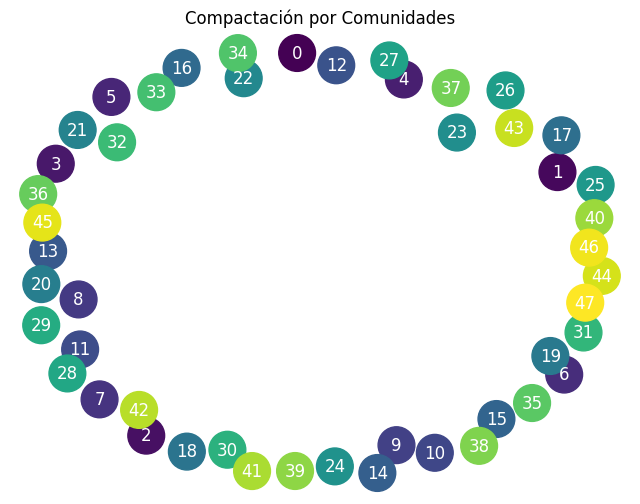

In [26]:
# Agregar nodos para cada comunidad
for community in range(len(partition)):
    compact_graph.add_node(community)

# Agregar aristas con pesos entre comunidades
for u, v in G.edges():
    if u in node_to_community and v in node_to_community:
        community_u = node_to_community[u]
        community_v = node_to_community[v]
        if community_u != community_v:  # Conexiones entre comunidades distintas
            if compact_graph.has_edge(community_u, community_v):
                compact_graph[community_u][community_v]['weight'] += 1
            else:
                compact_graph.add_edge(community_u, community_v, weight=1)

# Visualización del grafo compacto
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(compact_graph, seed=42)

# Dibujar nodos de las comunidades
nx.draw_networkx_nodes(
    compact_graph,
    pos,
    node_color=range(len(compact_graph.nodes())),
    cmap=plt.cm.viridis,
    node_size=700,
)

# Dibujar aristas con etiquetas de peso
nx.draw_networkx_edges(compact_graph, pos, width=2, alpha=0.6)
nx.draw_networkx_labels(compact_graph, pos, font_size=12, font_color="white")
edge_labels = nx.get_edge_attributes(compact_graph, 'weight')
nx.draw_networkx_edge_labels(compact_graph, pos, edge_labels=edge_labels)

plt.title("Compactación por Comunidades")
plt.axis("off")
plt.show()

In [259]:
G_compactado = G_igraph.contract_vertices(partition.membership)
# Simplificar el grafo compactado eliminando bucles y aristas duplicadas
G_compactado = G_compactado.simplify(combine_edges=dict(weight="sum"))
# G_compactado.simplify(combine_edges="sum")

print(f"El grafo compactado tiene {G_compactado.vcount()} nodos y {G_compactado.ecount()} aristas.")

layout = G_compactado.layout("fr")  # Usar layout de fuerza (opcional)
ig.plot(G_compactado, layout=layout, vertex_label=list(range(len(partition))), 
        vertex_color="lightblue", edge_width=1.5, bbox=(400, 400))

AttributeError: 'NoneType' object has no attribute 'simplify'

## **3. Métricas de comunidades**